<a href="https://colab.research.google.com/github/Cloblak/ad_photo_recommendation/blob/main/Notebooks/Facebook_Post_RecSys_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facebook Post Recommender

In [6]:
import pickle
import shutil
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
import random

import torch
from torchvision import models
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

## Download Images

In [7]:
!pip install img2dataset

In [8]:
!img2dataset --url_list=img_list.txt --output_folder=output_folder --thread_count=64 --image_size=256

Starting the downloading of this file
Sharding file number 1 of 1 called C:/Users/Chris/Desktop/MIDS/Spring_2022/AIPI_DeepLearning/Rec/ad_photo_recommendation/img_list.txt
File sharded in 1 shards
worker  - success: 0.179 - failed to download: 0.821 - failed to resize: 0.000 - images per sec: 34 - count: 168
total   - success: 0.179 - failed to download: 0.821 - failed to resize: 0.000 - images per sec: 34 - count: 168



0it [00:00, ?it/s]
1it [00:10, 10.07s/it]
1it [00:10, 10.07s/it]


In [9]:
# Save folder as a zip file
shutil.make_archive('output_folder', 'zip', 'output_folder') # Save folder as a zip file

'C:\\Users\\Chris\\Desktop\\MIDS\\Spring_2022\\AIPI_DeepLearning\\Rec\\ad_photo_recommendation\\output_folder.zip'

In [10]:
%ls

 Volume in drive C is Acer
 Volume Serial Number is 64A4-6F31

 Directory of C:\Users\Chris\Desktop\MIDS\Spring_2022\AIPI_DeepLearning\Rec\ad_photo_recommendation

04/04/2022  07:05 PM    <DIR>          .
04/04/2022  07:05 PM    <DIR>          ..
03/31/2022  08:25 PM             1,928 .gitignore
04/04/2022  06:59 PM    <DIR>          .ipynb_checkpoints
03/31/2022  08:26 PM    <DIR>          data
04/04/2022  03:05 PM         1,402,883 Facebook_Post_RecSys_Experiments.ipynb
04/04/2022  02:59 PM         1,283,613 Facebook_Post_RecSys_Experiments_WW.ipynb
04/04/2022  02:59 PM            21,031 fb_images.csv
04/04/2022  02:59 PM    <DIR>          images_only
04/04/2022  02:59 PM            44,582 img_list.txt
04/04/2022  02:59 PM    <DIR>          inputImagesCNN
03/31/2022  08:25 PM             1,095 LICENSE
04/04/2022  07:08 PM    <DIR>          output_folder
04/04/2022  07:08 PM         3,647,910 output_folder.zip
04/04/2022  02:59 PM           157,489 PyschobunnyAllVectors.pkl
03/31/2022

In [11]:
# Get all image names in the folder
image_names = []
for filename in os.listdir('output_folder/00000'):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        print(filename)
        image_names.append(filename)

# Get the URL of each image
urls = []
for imagename in image_names:
  url = pd.read_json("output_folder/00000/"+imagename.replace("jpg", "json"), typ='series')[0]
  urls.append(url)

000000002.jpg
000000003.jpg
000000010.jpg
000000015.jpg
000000016.jpg
000000020.jpg
000000025.jpg
000000027.jpg
000000030.jpg
000000031.jpg
000000043.jpg
000000044.jpg
000000048.jpg
000000050.jpg
000000052.jpg
000000053.jpg
000000054.jpg
000000059.jpg
000000061.jpg
000000063.jpg
000000067.jpg
000000068.jpg
000000073.jpg
000000075.jpg
000000079.jpg
000000080.jpg
000000081.jpg
000000082.jpg
000000083.jpg
000000085.jpg
000000093.jpg
000000097.jpg
000000101.jpg
000000105.jpg
000000111.jpg
000000115.jpg
000000117.jpg
000000118.jpg
000000121.jpg
000000122.jpg
000000126.jpg
000000129.jpg
000000130.jpg
000000131.jpg
000000133.jpg
000000138.jpg
000000139.jpg
000000140.jpg
000000141.jpg
000000142.jpg
000000143.jpg
000000144.jpg
000000145.jpg
000000146.jpg
000000147.jpg
000000148.jpg
000000149.jpg
000000150.jpg
000000151.jpg
000000152.jpg
000000153.jpg
000000154.jpg
000000155.jpg
000000156.jpg
000000157.jpg
000000158.jpg
000000159.jpg
000000160.jpg
000000161.jpg
000000162.jpg
000000163.jpg
000000

In [12]:
pd.set_option('display.max_colwidth', None)
fb_images = pd.DataFrame({"Image_Name": image_names, "URL":urls})
fb_images.head(2)

,Image_Name,URL
0,000000002.jpg,https://scontent-iad3-2.xx.fbcdn.net/v/t39.30808-6/277163972_5289518664405932_5738186889722457019_n.jpg?_nc_cat=106&ccb=1-5&_nc_sid=730e14&_nc_ohc=wRBfOASqMhsAX_eHUKb&_nc_ht=scontent-iad3-2.xx&oh=00_AT-zrWSvPj6fVV0VUhXZj_eLNk5yc2JyttCtwBdQHHe7wA&oe=6247E149
1,000000003.jpg,https://scontent-iad3-2.xx.fbcdn.net/v/t39.30808-6/277161994_5289518667739265_7461689358787468785_n.jpg?_nc_cat=105&ccb=1-5&_nc_sid=730e14&_nc_ohc=dGIhxDvQNkIAX-4e7tt&_nc_ht=scontent-iad3-2.xx&oh=00_AT8Zf_yc6GMT7-gcO2UL_2ZNAbJ-H0xj17A6i1Gtzy75Rw&oe=6247CB42


In [98]:
#fb_images.to_csv("fb_images.csv")

## Embeddings

In [ ]:
# Copy the image folder to clean it by removing json files and keep only jpg's
%cp -av output_folder/00000 images_only

In [58]:
# Remove json files
dir_name = "images_only"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".json"):
        os.remove(os.path.join(dir_name, item))

In [59]:
inputDim = (224,224)
inputDir = "images_only"
inputDirCNN = "inputImagesCNN"

os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])


for imageName in os.listdir(inputDir):
  try:
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)

    newI.save(os.path.join(inputDirCNN, imageName))
    
    newI.close()
    I.close()
  except Exception as e:
    pass
    print(e)
    logging.error(traceback.format_exc())


In [60]:
class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # Normalization to comply with the expected format by ResNet-18
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

# Generate Embeddings
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("inputImagesCNN")):
  try:
    I = Image.open(os.path.join("inputImagesCNN", image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close() 
  except:
    pass

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Converting images to feature vectors:


100%|██████████| 75/75 [00:08<00:00,  9.20it/s]


In [66]:
# Save embedding vectors
with open('PyschobunnyAllVectors.pkl', 'wb') as handle:
    pickle.dump(allVectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('PyschobunnyAllVectors.pkl', 'rb') as handle:
    allVectors = pickle.load(handle)

# close file
f.close()

## Recommendation System

In [67]:
def getSimilarityMatrix(vectors):
    """
    Function to calculate the cosine similarity between vectors.
    
    Parameters
    ----------
    vectors : matrix
        Matrix with all of the embeddings.

    matrix : dataframe
        Dataframe with the cosine similarity between all vectors.
    """
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [69]:
# Top 10 Images
k = 10 

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

# Save the model    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 75/75 [00:00<00:00, 1587.89it/s]


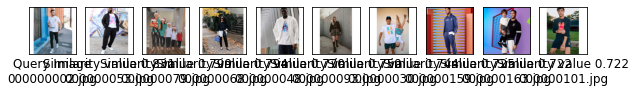

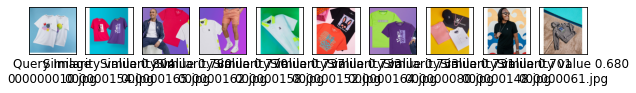

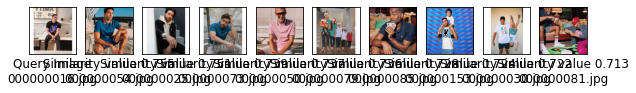

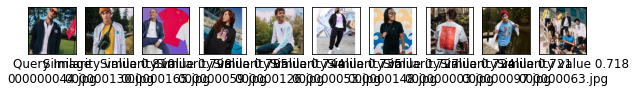

In [82]:
# Let's take the top images for some example images
inputImages = ['000000002.jpg', '000000010.jpg', '000000016.jpg', '000000044.jpg']

numCol = 10
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(10, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)

In [95]:
def plot_images(images, figsize = (16,16), w=10, h=10, columns=6, rows=6):
  """
  Function to plot several images.
  
  Parameters
  ----------
  images : list
      List of image names.
  """
  fig = plt.figure(figsize=figsize)
  count = 1
  
  for image in images:
      img = Image.open(os.path.join(inputDir, image))
      fig.add_subplot(rows, columns, count)
      count +=1
      plt.imshow(img)
  plt.show()

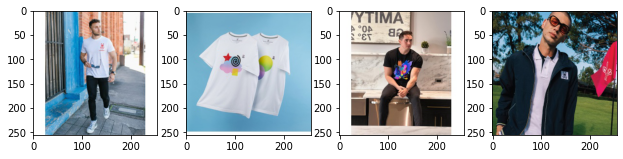

In [77]:
liked_images = ['000000002.jpg', '000000010.jpg', '000000016.jpg', '000000044.jpg']
plot_images(liked_images)

In [88]:
# Get recommendations
recos = []
for image in liked_images:
  simImages, simValues = getSimilarImages(image, similarNames, similarValues)
  all_images = [image]
  all_images.extend(simImages)
  recos.extend(all_images)

The first column has the "query" images so each row contains the recommendations for each query image.


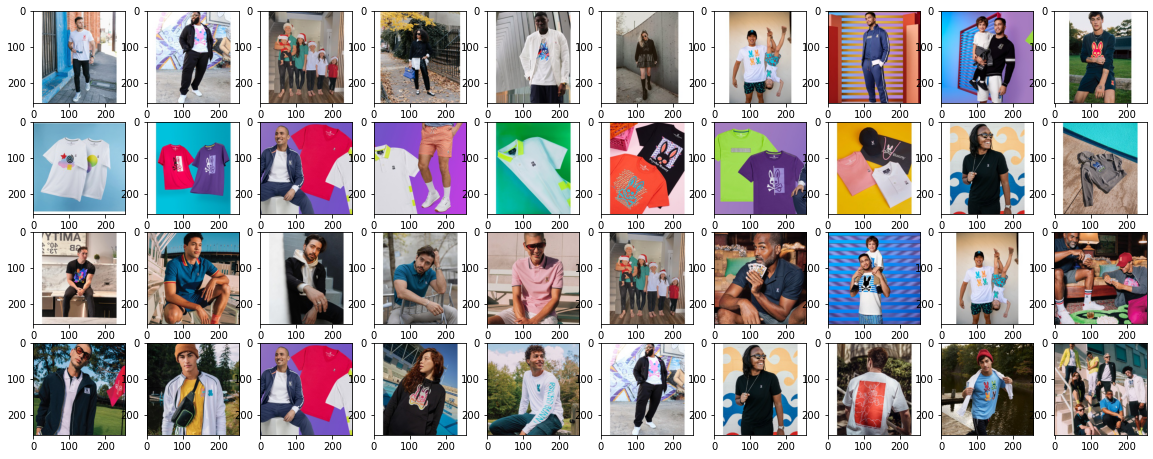

In [97]:
plot_images(recos, figsize = (20,20), w=20, h=20, columns=10, rows=10)